In [8]:
library(ggplot2)
library(readr)
library(rjson)
library(reshape2)
library(h2o)
library(caret)
library(data.table)

In [9]:
N_read <- -1

In [10]:
### Get starting & ending longitude and latitude
get_coordinate <- function(row){
  lonlat    <- fromJSON(row)
  snapshots <- length(lonlat)  
  start     <- lonlat[[1]]
  end       <- lonlat[[snapshots]]
  return(list(start[1], start[2], end[1], end[2], snapshots))
}

In [73]:
HaversineDistance <- function(lat1, lon1, lat2, lon2)
{
  # returns the distance in m
  REarth <- 6371000
  lat  <- abs(lat1-lat2)*pi/180
  lon  <- abs(lon1-lon2)*pi/180
  lat1 <- lat1*pi/180
  lat2 <- lat2*pi/180
  a    <- sin(lat/2)*sin(lat/2)+cos(lat1)*cos(lat2)*sin(lon/2)*sin(lon/2)
  d    <- 2*atan2(sqrt(a), sqrt(1-a))
  d    <- REarth*d
  return(d)
}

In [11]:
RMSE <- function(pre, real)
{
  return(sqrt(mean((pre-real)*(pre-real))))
}

In [12]:
meanHaversineDistance <- function(lat1, lon1, lat2, lon2)
{
  return(mean(HaversineDistance(lat1, lon1, lat2, lon2)))
}

In [14]:
setwd("/root/hackerday/03_taxi_trip/")
meta_data <- read.csv('metaData_taxistandsID_name_GPSlocation.csv', 
                      stringsAsFactors=FALSE, dec=".")
test  <- read_csv("test.csv")
train <- read_csv("training_sample.csv")

In [13]:
get_dist <- function(lon1, lat1, lon2, lat2) {  
  lon_diff <- abs(lon1-lon2)*pi/360
  lat_diff <- abs(lat1-lat2)*pi/360
  a        <- sin(lat_diff)^2 + cos(lat1) * cos(lat2) * sin(lon_diff)^2  
  d        <- 2*6371000*atan2(sqrt(a), sqrt(1-a))
  return(d)
}

,Longitude,Latitude
1,-8.60967,41.1771457135
2,-8.591064,41.15618964
3,-8.665876,41.1705249231
4,-8.621803,41.1437639911
5,-8.612726,41.1835097223
6,-8.582783,41.1808043369


Warning message:
In xy.coords(x, y, xlabel, ylabel, log): NAs introduced by coercion

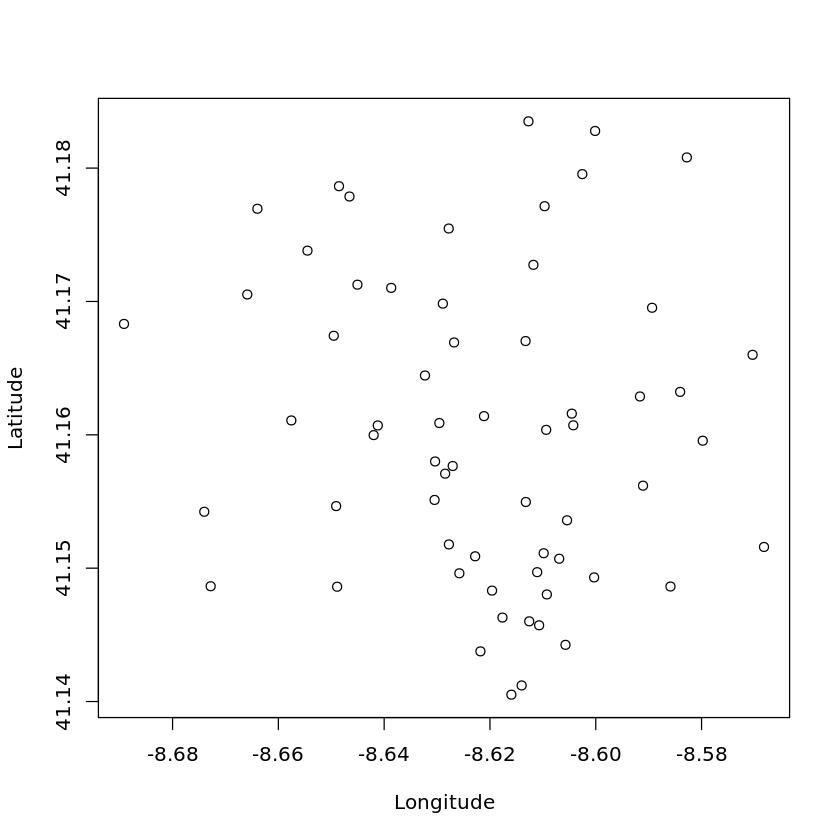

In [20]:
head(meta_data[, c(4, 3)])
plot(meta_data[, c(4, 3)])

In [21]:
# Change variable names
names(test)      <- tolower(names(test))
names(train)     <- tolower(names(train))
names(meta_data) <- tolower(names(meta_data))

In [25]:
# Change meta_dat variable id name to origin_stand
names(meta_data)[1] <- 'origin_stand'

In [26]:
# Change missing_data zand call_type from character to factor
train$missing_data <- as.factor(train$missing_data)
test$missing_data  <- as.factor(test$missing_data)
train$call_type    <- as.factor(train$call_type)
test$call_type     <- as.factor(test$call_type)

In [27]:
# Delete day_type
test$day_type  <- NULL
train$day_type <- NULL

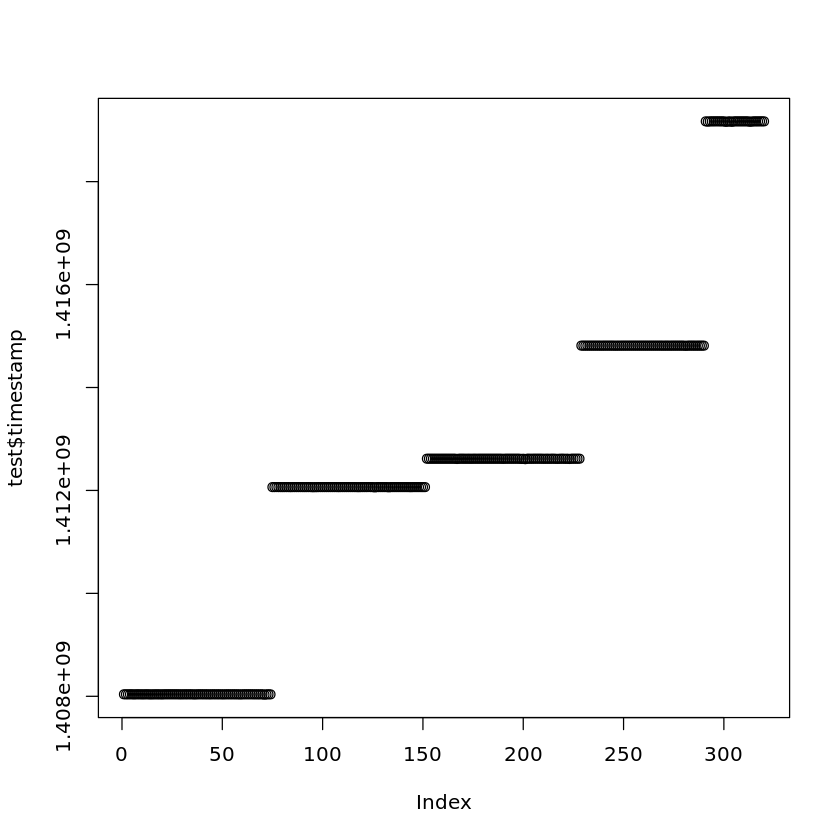

In [28]:
plot(test$timestamp)

In [37]:

#install.packages("tm",repos="https://cran.r-project.org/")
# Make a new variable with time in POSIXct format
library(RgoogleMaps)
library(colorRamps)
library(tm)
library(chron)

In [38]:
format_alg <- function(i, n)
{
  s <- sprintf("%d", n)
  while(nchar(s)<i)
  {
    s <- sprintf("0%s", s)
  }
  return(s)
}

In [43]:
miliseconds_to_date <- function(dt)
{
  # Obtain the mdy$year, mdy$month and mdy$day from timestamp
  mdy <- month.day.year((dt/3600/24))
  
  final <- as.Date(x=paste(mdy$year, "/", mdy$month, "/", mdy$day, sep=""), 
                   format="%Y/%m/%d")
  
  return(final)
}


In [44]:
test$date  <- miliseconds_to_date(test$timestamp)
train$date <- miliseconds_to_date(train$timestamp)


In [48]:
test$time  <- as.POSIXct(test$timestamp, origin="1970-01-01")
train$time <- as.POSIXct(train$timestamp, origin="1970-01-01")
head(test$time)

[1] "2014-08-14 17:57:17 UTC" "2014-08-14 17:50:11 UTC"
[3] "2014-08-14 17:49:28 UTC" "2014-08-14 17:58:10 UTC"
[5] "2014-08-14 17:59:37 UTC" "2014-08-14 17:25:46 UTC"

In [49]:
test$weekday <- factor(weekdays(test$date), levels=c("lunes", "martes", 
                                                     "miércoles", "jueves",
                                                     "viernes", "sábado",
                                                     "domingo"))


In [50]:
train$weekday <- factor(weekdays(train$date), levels=c("lunes", "martes", 
                                                       "miércoles", "jueves",
                                                       "viernes", "sábado",
                                                       "domingo"))

In [53]:
#install.packages("lubridate",repos="https://cran.r-project.org/")
library(lubridate)
test$hour  <- hour(test$time)
train$hour <- hour(train$time)


Attaching package: ‘lubridate’

The following objects are masked from ‘package:chron’:

    days, hours, minutes, seconds, years

The following objects are masked from ‘package:data.table’:

    hour, mday, month, quarter, wday, week, yday, year

The following objects are masked from ‘package:h2o’:

    day, hour, month, week, year



In [58]:
library(data.table)
train_DT <- fread('training_sample.csv', select=c('TRIP_ID', 'POLYLINE'), 
                  stringsAsFactors=F, nrows=N_read)
test_DT  <- fread('test.csv', select=c('TRIP_ID', 'POLYLINE'), 
                  stringsAsFactors=F)

In [60]:
train_DT[, index:=-seq(.N, 1, -1)]
train_index <- train_DT$index
train_DT <- train_DT[POLYLINE!='[]']
test_DT[, index:=1:.N]
setkey(train_DT, index)
setkey(test_DT, index)

ERROR: Error in rbindlist(l, use.names, fill, idcol): Item 2 of list input is not a data.frame, data.table or list


            TRIP_ID
    1: 1.372638e+18
    2: 1.372640e+18
    3: 1.372640e+18
    4: 1.372637e+18
    5: 1.372643e+18
   ---             
85531: 1.404157e+18
85532: 1.404165e+18
85533: 1.403524e+18
85534: 1.402068e+18
85535: 1.404154e+18
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

ERROR: Error in rbindlist(l, use.names, fill, idcol): Item 2 of list input is not a data.frame, data.table or list


     TRIP_ID
  1:      T1
  2:      T2
  3:      T3
  4:      T4
  5:      T5
 ---        
316:    T323
317:    T324
318:    T325
319:    T326
320:    T327
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [61]:
# Get starting & ending position from POLYLINE
train_DT[, c('initial_longitude', 'initial_latitude', 'final_longitude', 
             'final_latitude', 'snapshots'):=get_coordinate(POLYLINE), by=index]
test_DT[, c('initial_longitude', 'initial_latitude', 'final_longitude', 
            'final_latitude', 'snapshots'):=get_coordinate(POLYLINE), by=index]

ERROR: Error in rbindlist(l, use.names, fill, idcol): Item 2 of list input is not a data.frame, data.table or list


            TRIP_ID
    1: 1.372638e+18
    2: 1.372640e+18
    3: 1.372640e+18
    4: 1.372637e+18
    5: 1.372643e+18
   ---             
85238: 1.404157e+18
85239: 1.404165e+18
85240: 1.403524e+18
85241: 1.402068e+18
85242: 1.404154e+18
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

ERROR: Error in rbindlist(l, use.names, fill, idcol): Item 2 of list input is not a data.frame, data.table or list


     TRIP_ID
  1:      T1
  2:      T2
  3:      T3
  4:      T4
  5:      T5
 ---        
316:    T323
317:    T324
318:    T325
319:    T326
320:    T327
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [64]:
# Delete POLYLINE values
library(data.table)
train_DT[, POLYLINE:=NULL]
test_DT[, POLYLINE:=NULL]

Warning message:
In `[.data.table`(train_DT, , `:=`(POLYLINE, NULL)): Adding new column 'POLYLINE' then assigning NULL (deleting it).

ERROR: Error in rbindlist(l, use.names, fill, idcol): Item 2 of list input is not a data.frame, data.table or list


            TRIP_ID  index initial_longitude initial_latitude final_longitude
    1: 1.372638e+18 -85535         -8.585145         41.16486       -8.628147
    2: 1.372640e+18 -85534         -8.600067         41.18270       -8.620371
    3: 1.372640e+18 -85533         -8.663409         41.18072       -8.662923
    4: 1.372637e+18 -85532         -8.613297         41.15439       -8.645607
    5: 1.372643e+18 -85531         -8.628228         41.16518       -8.660259
   ---                                                                       
85238: 1.404157e+18     -5         -8.606988         41.15025       -8.629884
85239: 1.404165e+18     -4         -8.612685         41.14046       -8.640945
85240: 1.403524e+18     -3         -8.674065         41.15393       -8.675955
85241: 1.402068e+18     -2         -8.645301         41.15890       -8.645301
85242: 1.404154e+18     -1         -8.574714         41.14268       -8.610264
       final_latitude snapshots
    1:       41.15752        64


Warning message:
In `[.data.table`(test_DT, , `:=`(POLYLINE, NULL)): Adding new column 'POLYLINE' then assigning NULL (deleting it).

ERROR: Error in rbindlist(l, use.names, fill, idcol): Item 2 of list input is not a data.frame, data.table or list


     TRIP_ID index initial_longitude initial_latitude final_longitude
  1:      T1     1         -8.585676         41.14852       -8.584884
  2:      T2     2         -8.610876         41.14557       -8.601894
  3:      T3     3         -8.585739         41.14856       -8.574903
  4:      T4     4         -8.613963         41.14117       -8.614638
  5:      T5     5         -8.619903         41.14804       -8.619894
 ---                                                                 
316:    T323   316         -8.570196         41.15948       -8.593308
317:    T324   317         -8.613873         41.14123       -8.629785
318:    T325   318         -8.648100         41.15254       -8.643303
319:    T326   319         -8.571699         41.15607       -8.569206
320:    T327   320         -8.574561         41.18018       -8.592345
     final_latitude snapshots
  1:       41.14662        11
  2:       41.16360        40
  3:       41.16772        40
  4:       41.14098         8
  5:      

In [67]:
head(test_DT)
head(train_DT)


,TRIP_ID,index,initial_longitude,initial_latitude,final_longitude,final_latitude,snapshots
1,T1,1,-8.585676,41.14852,-8.584884,41.14662,11
2,T2,2,-8.610876,41.14557,-8.601894,41.1636,40
3,T3,3,-8.585739,41.14856,-8.574903,41.16772,40
4,T4,4,-8.613963,41.14117,-8.614638,41.14098,8
5,T5,5,-8.619903,41.14804,-8.619894,41.14804,2
6,T6,6,-8.630613,41.17825,-8.62641,41.17196,137


,TRIP_ID,index,initial_longitude,initial_latitude,final_longitude,final_latitude,snapshots
1,1.372638e+18,-85535,-8.585145,41.16486,-8.628147,41.15752,64
2,1.37264e+18,-85534,-8.600067,41.1827,-8.620371,41.1472,45
3,1.37264e+18,-85533,-8.663409,41.18072,-8.662923,41.16343,145
4,1.372637e+18,-85532,-8.613297,41.15439,-8.645607,41.15436,32
5,1.372643e+18,-85531,-8.628228,41.16518,-8.660259,41.15905,21
6,1.372645e+18,-85530,-8.603631,41.14654,-8.59707,41.15704,23


In [68]:
# Make a new dataset througth data table
train2 <- as.data.frame(train_DT)
test2  <- as.data.frame(test_DT)

In [69]:
# Change variable names
names(test2)  <- tolower(names(test2))
names(train2) <- tolower(names(train2))

In [70]:
test$index  <- test2$index
train$index <- train_index
test3  <- merge(test[, c(1:7, 9:13)], test2, by.x="index", by.y="index")
train2$trip_id <- as.numeric(train2$trip_id)
index <- (1:nrow(train))[train$polyline!="[]"]
train3 <- merge(train[, c(1:7, 9:13)], train2, by.x="index", 
                by.y="index")

In [71]:
test3$trip_id.y  <- NULL
train3$trip_id.y <- NULL

In [74]:
test3$distance <- HaversineDistance(test3$initial_latitude, 
                                    test3$initial_longitude,
                                    test3$final_latitude,
                                    test3$final_longitude)

In [75]:
train3$distance <- HaversineDistance(train3$initial_latitude, 
                                     train3$initial_longitude,
                                     train3$final_latitude,
                                     train3$final_longitude)

In [76]:
# 5 day test dates. 365 days train dates.
date_test  <- unique(test3$date)
date_train <- unique(train3$date)

In [77]:
test4  <- test3
train4 <- train3

In [80]:
# We aggregate minute values in 15min groups
test4$minute  <- hour(test4$time)*60+(minute(test4$time)%/%15)*15
train4$minute <- hour(train4$time)*60+(minute(train4$time)%/%15)*15

In [81]:
# Speed greater than 30 m/s. Train: 1781. Test: 1 
train_speed <- train4$distance/((train4$snapshots-1)*15)
sum(train_speed>30, na.rm=TRUE)
test_speed <- test4$distance/((test4$snapshots-1)*15)
sum(test_speed>30, na.rm=TRUE)

[1] 82

[1] 1

In [85]:
names(train4)
names(test4)


[1] "index"             "trip_id.x"         "call_type"        
 [4] "origin_call"       "origin_stand"      "taxi_id"          
 [7] "timestamp"         "missing_data"      "date"             
[10] "time"              "weekday"           "hour"             
[13] "initial_longitude" "initial_latitude"  "final_longitude"  
[16] "final_latitude"    "snapshots"         "distance"         
[19] "minute"

[1] "index"             "trip_id.x"         "call_type"        
 [4] "origin_call"       "origin_stand"      "taxi_id"          
 [7] "timestamp"         "missing_data"      "date"             
[10] "time"              "weekday"           "hour"             
[13] "initial_longitude" "initial_latitude"  "final_longitude"  
[16] "final_latitude"    "snapshots"         "distance"         
[19] "minute"

In [88]:
library(h2o)



H2O is not running yet, starting it now...


ERROR: Error in .h2o.checkJava(): Cannot find Java. Please install the latest JDK from
http://www.oracle.com/technetwork/java/javase/downloads/index.html


In [94]:
library(randomForest)
fit <- randomForest(snapshots ~initial_longitude+initial_latitude+
                    call_type+minute,data=train4
                   )

In [96]:
fit


Call:
 randomForest(formula = snapshots ~ initial_longitude + initial_latitude +      call_type + minute, data = train4, ntrees = 10) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 1

          Mean of squared residuals: 2559.615
                    % Var explained: 3.78

In [98]:
pred039 <- data.frame(predict(fit, test4))
head(pred039)

,predict.fit..test4.
1,52.40386
2,50.78082
3,52.55426
4,49.82949
5,52.06856
6,54.71932


In [104]:
pred039_test_time <- data.frame(TRIP_ID=test4$trip_id, 
                                TRAVEL_TIME=(round(pred039)-1)*15)

#pred039_test_time$TRAVEL_TIME - (test4$snapshots-1)*15
negative <- (pred039_test_time$TRAVEL_TIME - (test4$snapshots-1)*15)<0
sum(negative)
pred039_test_time$TRAVEL_TIME[negative] <- ((test4$snapshots[negative]-1)*15)*1.45
names(pred039_test_time)=c('TRIP_ID','TRAVEL_TIME')

write.csv(pred039_test_time, 'pred039_test_time_RandomForest.csv', row.names=F)


[1] 0

In [105]:
head(pred039_test_time)

,TRIP_ID,TRAVEL_TIME
1,T1,765
2,T2,750
3,T3,780
4,T4,735
5,T5,765
6,T6,810
